In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI: Track parameters and metrics for locally trained models

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/experiments/comparing_local_trained_models.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/experiments/comparing_local_trained_models.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/experiments/comparing_local_trained_models.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

As a Data Scientist, you probably start running model experiments locally on your notebook. Depending on the framework you use, you would need to track parameters, training time series and evaluation metrics. In this way, you would be able to explain the modelling approach you would choose. 

Learn more about [Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments).

### Objective

In this tutorial, you learn how to use Vertex AI Experiments to compare and evaluate model experiments.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Workbench
- Vertex AI Experiments

The steps performed include:

- log the model parameters
- log the loss and metrics on every epoch to TensorBoard
- log the evaluation metrics


### Dataset

In this notebook, we will train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).


### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Vertex AI TensorBoard
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages

Install additional package dependencies not installed in your notebook environment, such as TensorFlow and Vertex AI SDK. Use the latest major GA version of each package.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

# ! pip3 install {USER_FLAG} tensorflow==2.8 google-cloud-aiplatform -q --no-warn-conflicts

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# # Automatically restart kernel after installs
# import os

# if not os.getenv("IS_TESTING"):
#     # Automatically restart kernel after installs
#     import IPython

#     app = IPython.Application.instance()
#     app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable APIs](https://console.cloud.google.com/flows/enableapi?apiid=cloudresourcemanager.googleapis.com,aiplatform.googleapis.com).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: mwpmltr


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Get your project number {TODO: Include these cells if the notebook uses a project number}
Now that the project ID is set, you get your corresponding project number.

In [4]:
shell_output = ! gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = shell_output[0]
print("Project Number:", PROJECT_NUMBER)

Project Number: 55590906972


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [5]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
# import random
# import string


# # Generate a uuid of a specifed length(default=8)
# def generate_uuid(length: int = 8) -> str:
#     return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


# UUID = generate_uuid()

In [6]:
UUID='0obvksai'

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type and select
the following role into the filter box:

    *   Storage Admin
    *   Storage Object Admin
    *   Service Account User
    *   Vertex AI Administrator


5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [7]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [8]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [9]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "-aip-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
# ! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [10]:
! gsutil ls -al $BUCKET_URI

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [11]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on Google Cloud Notebooks, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Import libraries

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.utils import data_utils

2023-03-18 17:36:38.647978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-18 17:36:38.648023: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define constants

In [13]:
EXPERIMENT_NAME = "[your-experiment-name]"  # @param {type:"string"}

If EXPERIMENT_NAME is not set, set a default one below:

In [14]:
if EXPERIMENT_NAME == "[your-experiment-name]" or EXPERIMENT_NAME is None:
    EXPERIMENT_NAME = "my-experiment-" + UUID

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [15]:
vertex_ai.init(project=PROJECT_ID, location=REGION)

### Create TensorBoard instance using Vertex AI TensorBoard

You can upload your TensorBoard logs by first creating a Vertex AI TensorBoard instance.

**Notice** that if you did not activate yet, Vertex AI TensorBoard charges a monthly fee of $300 per unique active user. 

Learn more about [TensorBoard overview](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview).

In [16]:
vertex_ai_tb = vertex_ai.Tensorboard.create()

Creating Tensorboard
Create Tensorboard backing LRO: projects/55590906972/locations/us-central1/tensorboards/4134841019600470016/operations/5521300786811764736
Tensorboard created. Resource name: projects/55590906972/locations/us-central1/tensorboards/4134841019600470016
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/55590906972/locations/us-central1/tensorboards/4134841019600470016')


In [17]:
vertex_ai.init(experiment=EXPERIMENT_NAME, experiment_tensorboard=vertex_ai_tb)

## Training with Vertex AI Experiments

Vertex AI enables users to track the steps (for example, preprocessing, training) of an experiment run, and track inputs (for example, algorithm, parameters, datasets) and outputs (for example, models, checkpoints, metrics) of those steps. 

To better understanding how parameters and metrics are stored and organized, the following concepts are explained:

1. **Experiments** describe a context that groups your runs and the artifacts you create into a logical session. For example, in this notebook you create an Experiment and log data to that experiment.

1. **Run** represents a single path/avenue that you executed while performing an experiment. A run includes artifacts that you used as inputs or outputs, and parameters that you used in this execution. An Experiment can contain multiple runs. 

You can use the  Vertex AI SDK for Python to track metrics and parameters models trained locally for each experiment across several experiment runs. 

In the following example, you train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

In [18]:
# Helpers ----------------------------------------------------------------------


def read_data(uri):
    """
    Read data
    Args:
        uri: path to data
    Returns:
        pandas dataframe
    """
    dataset_path = data_utils.get_file("auto-mpg.data", uri)
    column_names = [
        "MPG",
        "Cylinders",
        "Displacement",
        "Horsepower",
        "Weight",
        "Acceleration",
        "Model Year",
        "Origin",
    ]
    raw_dataset = pd.read_csv(
        dataset_path,
        names=column_names,
        na_values="?",
        comment="\t",
        sep=" ",
        skipinitialspace=True,
    )
    dataset = raw_dataset.dropna()
    dataset["Origin"] = dataset["Origin"].map(
        lambda x: {1: "USA", 2: "Europe", 3: "Japan"}.get(x)
    )
    dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
    return dataset


def train_test_split(dataset, split_frac=0.8, random_state=0):
    """
    Split data into train and test
    Args:
        dataset: pandas dataframe
        split_frac: fraction of data to use for training
        random_state: random seed
    Returns:
        train and test dataframes
    """
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop("MPG")
    test_labels = test_dataset.pop("MPG")

    return train_dataset, test_dataset, train_labels, test_labels


def normalize_dataset(train_dataset, test_dataset):
    """
    Normalize data
    Args:
        train_dataset: pandas dataframe
        test_dataset: pandas dataframe

    Returns:

    """
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()

    def norm(x):
        return (x - train_stats["mean"]) / train_stats["std"]

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, normed_test_data


def build_model(num_units, dropout_rate):
    """
    Build model
    Args:
        num_units: number of units in hidden layer
        dropout_rate: dropout rate
    Returns:
        compiled model
    """
    model = Sequential(
        [
            layers.Dense(
                num_units,
                activation="relu",
                input_shape=[9],
            ),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(num_units, activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
    return model


def train(
    model,
    train_data,
    train_labels,
    validation_split=0.2,
    epochs=10,
):
    """
    Train model
    Args:
        train_data: pandas dataframe
        train_labels: pandas dataframe
        model: compiled model
        validation_split: fraction of data to use for validation
        epochs: number of epochs to train for
    Returns:
        history
    """
    history = model.fit(
        train_data, train_labels, epochs=epochs, validation_split=validation_split
    )

    return history

### Run experiment and evaluate experiment runs

You define several experiment configurations, run experiments and track them in Vertex AI Experiments

In [19]:
# Define experiment parameters
parameters = [
    {"num_units": 16, "dropout_rate": 0.1, "epochs": 3},
    {"num_units": 16, "dropout_rate": 0.1, "epochs": 10},
    {"num_units": 16, "dropout_rate": 0.2, "epochs": 10},
    {"num_units": 32, "dropout_rate": 0.1, "epochs": 10},
    {"num_units": 32, "dropout_rate": 0.2, "epochs": 10},
]

# Read data
dataset = read_data(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

# Split data
train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

# Normalize data
normed_train_data, normed_test_data = normalize_dataset(train_dataset, test_dataset)

# Run experiments
for i, params in enumerate(parameters):

    # Initialize Vertex AI Experiment run
    vertex_ai.start_run(run=f"auto-mpg-local-run-{i}")

    # Log training parameters
    vertex_ai.log_params(params)

    # Build model
    model = build_model(
        num_units=params["num_units"], dropout_rate=params["dropout_rate"]
    )

    # Train model
    history = train(
        model,
        normed_train_data,
        train_labels,
        epochs=params["epochs"],
    )

    # Log additional parameters
    vertex_ai.log_params(history.params)

    # Log metrics per epochs
    for idx in range(0, history.params["epochs"]):
        vertex_ai.log_time_series_metrics(
            {
                "train_mae": history.history["mae"][idx],
                "train_mse": history.history["mse"][idx],
            }
        )

    # Log final metrics
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
    vertex_ai.log_metrics({"eval_loss": loss, "eval_mae": mae, "eval_mse": mse})

    vertex_ai.end_run()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Associating projects/55590906972/locations/us-central1/metadataStores/default/contexts/my-experiment-0obvksai-auto-mpg-local-run-0 to Experiment: my-experiment-0obvksai


2023-03-18 17:37:04.985418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-18 17:37:04.985474: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 17:37:04.985501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aaa-aca-workshop-bjacob): /proc/driver/nvidia/version does not exist
2023-03-18 17:37:04.985822: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
8/8 [==============================] - 1s 25ms/step - loss: 622.8967 - mae: 23.7018 - mse: 622.8967 - val_loss: 646.6120 - val_mae: 24.1691 - val_mse: 646.6120
Epoch 2/3
8/8 [==============================] - 0s 5ms/step - loss: 614.4867 - mae: 23.5325 - mse: 614.4867 - val_loss: 637.7242 - val_mae: 23.9891 - val_mse: 637.7242
Epoch 3/3
8/8 [==============================] - 0s 5ms/step - loss: 606.9105 - mae: 23.3744 - mse: 606.9105 - val_loss: 629.4601 - val_mae: 23.8196 - val_mse: 629.4601
3/3 - 0s - loss: 646.0430 - mae: 24.0717 - mse: 646.0430
Associating projects/55590906972/locations/us-central1/metadataStores/default/contexts/my-experiment-0obvksai-auto-mpg-local-run-1 to Experiment: my-experiment-0obvksai
Epoch 1/10
8/8 [==============================] - 1s 21ms/step - loss: 598.7259 - mae: 23.1842 - mse: 598.7259 - val_loss: 622.2471 - val_mae: 23.6352 - val_mse: 622.2471
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 588.2034 - mae: 22.9763 -

### Extract parameters and metrics into a dataframe for analysis

We can also extract all parameters and metrics associated with any Experiment into a dataframe for further analysis.

In [20]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df.T

,0,1,2,3,4,5,6,7,8,9
experiment_name,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai,my-experiment-0obvksai
run_name,auto-mpg-local-run-4,auto-mpg-local-run-3,auto-mpg-local-run-2,auto-mpg-local-run-1,auto-mpg-local-run-0,auto-mpg-local-run-4,auto-mpg-local-run-3,auto-mpg-local-run-2,auto-mpg-local-run-1,auto-mpg-local-run-0
run_type,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun,system.ExperimentRun,system.Run,system.Run,system.Run,system.Run,system.Run
state,COMPLETE,COMPLETE,COMPLETE,COMPLETE,COMPLETE,STATE_UNSPECIFIED,STATE_UNSPECIFIED,STATE_UNSPECIFIED,STATE_UNSPECIFIED,STATE_UNSPECIFIED
param.dropout_rate,0.2,0.1,0.2,0.1,0.1,0.2,0.1,0.2,0.1,0.1
param.steps,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
param.epochs,10.0,10.0,10.0,10.0,3.0,10.0,10.0,10.0,10.0,3.0
param.num_units,32.0,32.0,16.0,16.0,16.0,32.0,32.0,16.0,16.0,16.0
param.verbose,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
metric.eval_loss,497.954529,314.953644,540.879028,515.694885,646.042969,370.000488,358.033905,507.404358,550.917847,610.503479


### Visualizing an experiment's parameters and metrics

You use parallel coordinates plotting to visualize experiment's parameters and metrics

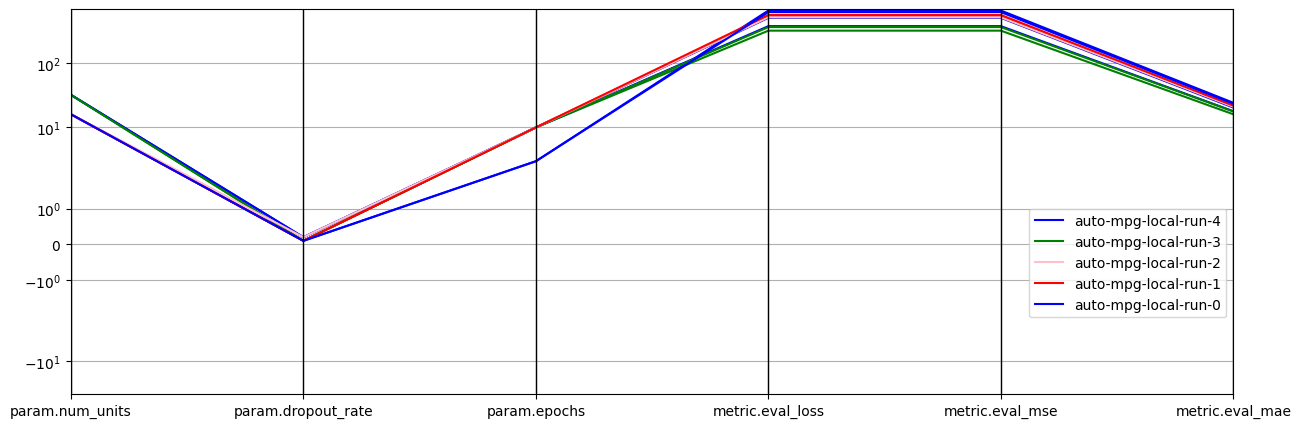

In [21]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    "run_name",
    cols=[
        "param.num_units",
        "param.dropout_rate",
        "param.epochs",
        "metric.eval_loss",
        "metric.eval_mse",
        "metric.eval_mae",
    ],
    color=["blue", "green", "pink", "red"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

## Visualizing experiments in Cloud Console

Run the following to get the URL of Vertex AI Experiments for your project.


In [22]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={PROJECT_ID}"
)

Vertex AI Experiments:
https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=mwpmltr


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [23]:
# Delete experiment
exp = vertex_ai.Experiment(EXPERIMENT_NAME)
exp.delete(delete_backing_tensorboard_runs=True)

# Delete Tensorboard
vertex_ai_tb.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}

Deleting TensorboardRun : projects/55590906972/locations/us-central1/tensorboards/4134841019600470016/experiments/my-experiment-0obvksai/runs/auto-mpg-local-run-4
Delete TensorboardRun  backing LRO: projects/55590906972/locations/us-central1/tensorboards/4134841019600470016/experiments/my-experiment-0obvksai/operations/6931138576411262976
TensorboardRun deleted. . Resource name: projects/55590906972/locations/us-central1/tensorboards/4134841019600470016/experiments/my-experiment-0obvksai/runs/auto-mpg-local-run-4
Deleting Artifact : projects/55590906972/locations/us-central1/metadataStores/default/artifacts/my-experiment-0obvksai-auto-mpg-local-run-4-tb-run
Delete Artifact  backing LRO: projects/55590906972/locations/us-central1/metadataStores/default/artifacts/my-experiment-0obvksai-auto-mpg-local-run-4-tb-run/operations/7395009338030424064
Artifact deleted. . Resource name: projects/55590906972/locations/us-central1/metadataStores/default/artifacts/my-experiment-0obvksai-auto-mpg-loc